# Initial attempt to learn from SF data

We use only basic algorithms

In [1]:
import os
import sqlite3
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem.Descriptors import rdMolDescriptors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, os.path.abspath('../..'))

from src.definitions import DB_PATH
from src.util.db_utils import SynFermDatabaseConnection

In [2]:
db = SynFermDatabaseConnection()  # we will use this for various simple queries

In [3]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False)
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 58664


In [4]:
# select experiment numbers for further analysis
start_exp_nr = 4  # kick out invalid experiments (SOP changed after exp3)
end_exp_nr = 29  # (inclusive)

df_full = df_full.loc[df_full['exp_nr'].between(start_exp_nr, end_exp_nr)]  
                      
print(f'Number of reactions considered here: {len(df_full)}')

Number of reactions considered here: 49920


In [5]:
# doublecheck that there are no "empty" experiments where results are missing
df_full[df_full["product_A_lcms_ratio"].isna()]

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_A_smiles,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid
id,,,,,,,,,,,,,,,,,,,,,


In [6]:
df_full.loc[~df_full["valid"].str.contains("ERROR", na=False), "valid"].value_counts().index

Index(['WARNING: multiple peaks for product A (2)',
       'WARNING: multiple peaks for product A (3)',
       'WARNING: multiple peaks for product A (4)',
       'WARNING: heating failure on first step',
       'WARNING: heating failure on first step; WARNING: multiple peaks for product A (2)',
       'WARNING: heating failure on first step; WARNING: multiple peaks for product A (3)',
       'WARNING: QC T9 peak not found', 'WARNING: QC M36 [M-2+H]+ found',
       'WARNING: QC M53 peak not found', 'WARNING: QC M48 peak not found',
       'WARNING: heating failure on first step; WARNING: multiple peaks for product A (4)',
       'WARNING: QC M27 contaminated', 'WARNING: QC M39 contaminated',
       'WARNING: QC M36 peak not found', 'WARNING: bad LCMS I45',
       'WARNING: bad LCMS I56', 'WARNING: QC M11 contaminated',
       'WARNING: QC I45 peak not found', 'WARNING: QC I57 peak not found',
       'WARNING: QC M12 contaminated', 'WARNING: QC I56 acid found',
       'WARNING: QC I17 p

In [7]:
df_full["valid"].isna().value_counts()

False    26104
True     23816
Name: valid, dtype: int64

In [8]:
# remove everything that says ERROR
df_full = df_full.loc[~df_full["valid"].str.contains("ERROR", na=False)]
len(df_full)

41735

<Axes: ylabel='Frequency'>

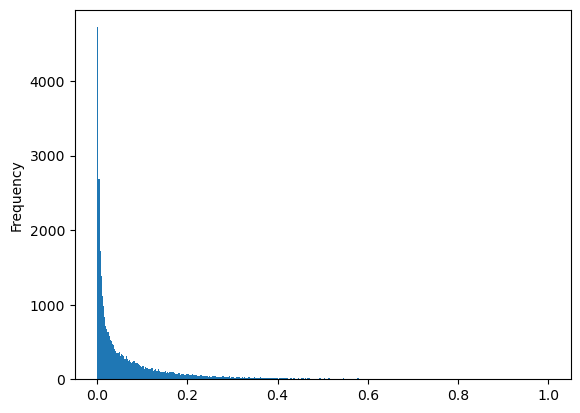

In [9]:
# plot everything with a value > 0
df_full.loc[df_full["product_A_lcms_ratio"].between(1e-10,1), "product_A_lcms_ratio"].plot.hist(bins=400)

In [10]:
# We assign classes 0 (failure) and 1 (success) by >0

df_full["product_A_outcome"] = 0
df_full.loc[df_full["product_A_lcms_ratio"] > 0, "product_A_outcome"] = 1

In [11]:
df_full["product_A_outcome"].value_counts()

1    32519
0     9216
Name: product_A_outcome, dtype: int64

In [12]:
# %pos class
df_full["product_A_outcome"].value_counts()[1] / len(df_full)

0.7791781478375465

In [13]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

get_descriptors = rdMolDescriptors.Properties(descriptor_names)

def smi_to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors

In [14]:
df_full['descriptors'] = df_full["product_A_smiles"].apply(smi_to_descriptors)

In [15]:
df_pred = df_full.dropna(subset=["descriptors", "product_A_outcome"])

In [16]:
# extract our data
X = np.stack(df_pred["descriptors"].values.tolist())
y = df_pred["product_A_outcome"].values

In [17]:
X.shape

(41735, 43)

In [18]:
y.shape

(41735,)

In [19]:
# train-test split (produce indices)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [20]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [21]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [22]:
# hparam search
val_scores = []
Cs = np.logspace(-3, 4, num=100)
for C in Cs:
    model = LogisticRegression(C=C, solver="newton-cholesky")
    model.fit(X_train, y_train)
    y_hat = model.predict(X_val)
    val_scores.append(accuracy_score(y_val, y_hat))

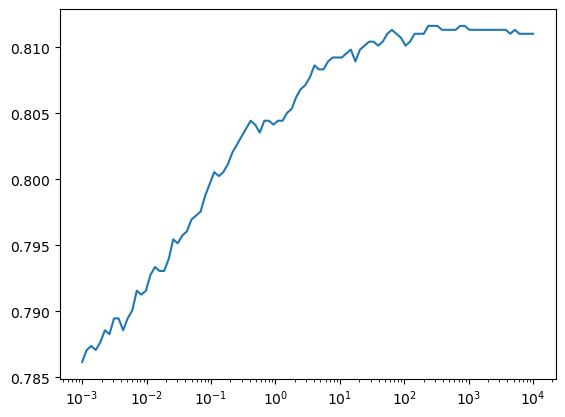

In [23]:
# show hparam search results
plt.plot(Cs, val_scores)
plt.xscale("log")
plt.show()

In [24]:
# best C
best_C = Cs[np.argmax(val_scores)]
print(best_C)

236.4489412645407


In [25]:
# refit best model and evaluate on test set
model = LogisticRegression(C=best_C, solver="newton-cholesky")
model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
y_hat = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_hat)}")
print(f"Balanced Accuracy: {np.sqrt(balanced_accuracy_score(y_test, y_hat))}")
print(f"F1-score: {np.sqrt(f1_score(y_test, y_hat))}")

Accuracy: 0.8095123996645501
Balanced Accuracy: 0.770292011345975
F1-score: 0.9429241075010362


In [26]:
y_test.mean()

0.7830358212531449

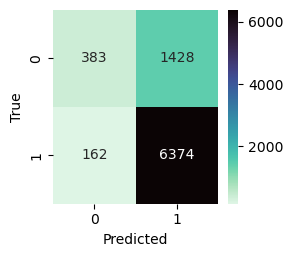

In [27]:
plt.figure(figsize=(3,2.67))
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, fmt="01", cmap=sns.color_palette("mako_r", as_cmap=True))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_LogReg_props.png", dpi=300)

In [28]:
# get highest coefficients
highest_coefs = np.argsort(np.abs(model.coef_.flatten()))[::-1]

In [29]:
# show most extreme coefficients with their names
for idx in highest_coefs[:5]:
    print(descriptor_names[idx])
    print(model.coef_.flatten()[idx])

NumHeavyAtoms
-66.09344012379077
chi0n
23.684953273425084
labuteASA
23.2248306944182
kappa1
21.41647542035254
exactmw
20.74856225371491


In [30]:
# helper function
def iterable_to_nested_list(list_to_break_up, inner_len, pad_last=False, pad_value=None):
    """Break up list into nested lists of given length"""
    # invert list for fast pop()
    list_tmp = list(reversed(list_to_break_up))

    outer_list = []
    while len(list_tmp) > 0:
        inner_list = []
        while len(inner_list) < inner_len:
            if len(list_tmp) == 0:
                if pad_last:
                    while len(inner_list) < inner_len:
                        inner_list.append(pad_value)
                break
            inner_list.append(list_tmp.pop())
        outer_list.append(inner_list)
    return outer_list

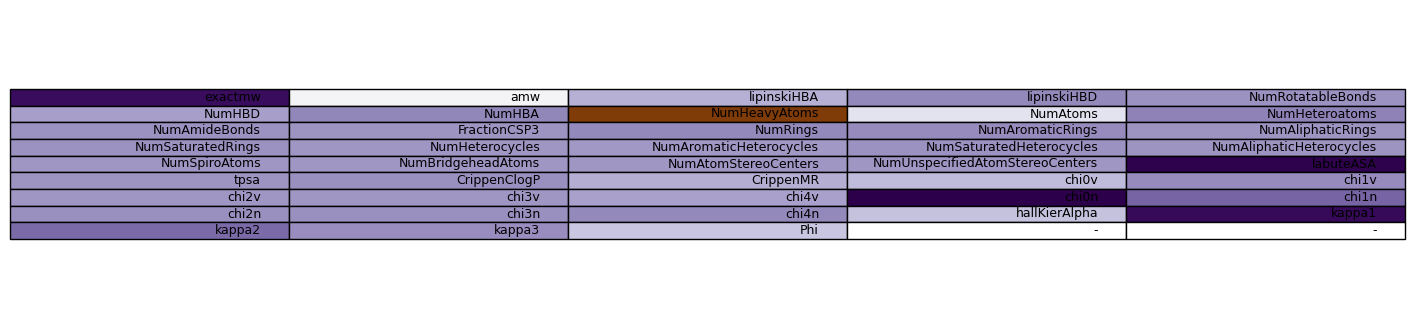

In [31]:
# show most extreme descriptors
fig, ax = plt.subplots(figsize=(18,4))
ax.axis('tight')
ax.axis('off')

norm = plt.Normalize()
colors = iterable_to_nested_list(cm.PuOr(norm(model.coef_.flatten())), 5,True,  np.array([1.,1.,1.,1.]))

ax.table(cellText = iterable_to_nested_list(descriptor_names, 5, True, "-"), cellColours=colors, loc='center')
plt.show()

In [32]:
# let's train a different model instead: OHE of reactants + FFN
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown="infrequent_if_exist")
df_OHE = df_pred[["initiator", "monomer", "terminator"]]
df_OHE

,initiator,monomer,terminator
id,,,
10578,I67,M20,T25
10579,I67,M20,T39
10580,I67,M20,T30
10581,I67,M20,T34
10584,I67,M20,T1
...,...,...,...
85516,I33,M22,T32
85517,I33,M22,T31
85518,I33,M22,T40


In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_OHE.values, y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [34]:
X_train_OHE = ohe.fit_transform(X_train)
X_val_OHE = ohe.transform(X_val)
X_test_OHE = ohe.transform(X_test)

In [35]:
import torch


In [36]:
class FFN(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.W_i = torch.nn.Linear(input_size, 600, bias=True)
        self.W_h = torch.nn.Linear(600, 400, bias=True)
        self.W_o = torch.nn.Linear(400, 1, bias=False)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        return self.W_o(self.activation(self.W_h(self.activation(self.W_i(x)))))

In [37]:
class SFDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [38]:
model = FFN(182)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [40]:
loss_fn = torch.nn.BCEWithLogitsLoss()

In [41]:
dataset_train = SFDataset(X_train_OHE, y_train)
dataset_val = SFDataset(X_val_OHE, y_val)
dataset_test = SFDataset(X_test_OHE, y_test)

In [42]:
training_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)

In [43]:
validation_loader = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=False)

In [44]:
next(iter(training_loader))

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.])]

In [45]:
torch.tensor([0,1]).reshape(-1,1).shape

torch.Size([2, 1])

In [46]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.reshape(-1, 1))
        
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        last_loss = running_loss / (i+1) # loss per batch
        #print('  batch {} loss: {}'.format(i + 1, last_loss))

    return last_loss


In [47]:
EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels.reshape(-1,1))
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}'.format(epoch)
        torch.save(model.state_dict(), model_path)



EPOCH 1:
LOSS train 0.3941321394708241 valid 0.254343718290329
EPOCH 2:
LOSS train 0.22086539068728767 valid 0.23811085522174835
EPOCH 3:
LOSS train 0.20218695716409657 valid 0.22649846971035004
EPOCH 4:
LOSS train 0.18728872533755667 valid 0.21766403317451477
EPOCH 5:
LOSS train 0.17172166461008284 valid 0.20958496630191803
EPOCH 6:
LOSS train 0.15370150381947895 valid 0.20200110971927643
EPOCH 7:
LOSS train 0.13343014774148731 valid 0.1943673938512802
EPOCH 8:
LOSS train 0.11235120422295637 valid 0.18910746276378632
EPOCH 9:
LOSS train 0.09390633269175075 valid 0.18606677651405334
EPOCH 10:
LOSS train 0.07743472300282088 valid 0.18832868337631226
EPOCH 11:
LOSS train 0.06294863426623921 valid 0.18453040719032288
EPOCH 12:
LOSS train 0.05133737967798755 valid 0.19925162196159363
EPOCH 13:
LOSS train 0.04100968219591711 valid 0.205088809132576
EPOCH 14:
LOSS train 0.03321077259370362 valid 0.22495749592781067
EPOCH 15:
LOSS train 0.026028576109536773 valid 0.2135491669178009
EPOCH 16:


In [48]:
model_path

'model_10'

In [49]:
best_model = FFN(182)
best_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [50]:
best_model.eval()

with torch.no_grad():
    pred = torch.sigmoid(model(dataset_test.X))
    print(pred)
    predicted, actual = (pred > 0.5).float(), dataset_test.y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

tensor([[2.2914e-07],
        [1.0000e+00],
        [2.2376e-02],
        ...,
        [1.0000e+00],
        [7.9058e-02],
        [1.0000e+00]])
Predicted: "tensor([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [1.]])", Actual: "tensor([0., 1., 0.,  ..., 1., 1., 1.])"


In [51]:
(pred > 0.5).count_nonzero()

tensor(8243)

In [52]:
accuracy_score(predicted, actual)

0.9305156220049837

In [63]:
# %pos class in test set
dataset_test.y.mean()

tensor(0.7823)

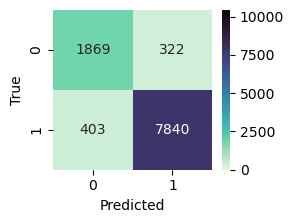

In [62]:
plt.figure(figsize=(3,2.33))
sns.heatmap(confusion_matrix(predicted, actual), vmin=0, vmax=len(dataset_test), annot=True, fmt="01", cmap=sns.color_palette("mako_r", as_cmap=True))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_FFN_OHE.png", dpi=300)

In [56]:
f1_score(predicted, actual)

0.955806156659555

In [57]:
balanced_accuracy_score(predicted, actual)

0.9020725882625165